In [1]:
import os
import glob
import json
import pandas as pd 
from pycocotools.coco import COCO
from PIL import Image
import numpy as np 
import skimage.io as io
from matplotlib import pyplot as plt
from pprint import pprint
import gc
%matplotlib inline

# 1. COCO annotation preview

In [3]:
# initialise COCO API for annotations
coco = COCO('turtles-data/data/annotations.json')

loading annotations into memory...
Done (t=10.30s)
creating index...
index created!


In [5]:
for key in coco.anns.keys():
    pprint(coco.anns[key])
    break 

{'area': 4065.0,
 'attributes': {'occluded': False, 'orientation': 'left'},
 'bbox': [644.0, 441.0, 70.0, 78.0],
 'category_id': 3,
 'id': 1,
 'image_id': 1,
 'iscrowd': 1,
 'segmentation': {'counts': [858927,
                             7,
                             1322,
                             23,
                             1306,
                             34,
                             1298,
                             36,
                             1296,
                             39,
                             1292,
                             42,
                             1291,
                             43,
                             1289,
                             45,
                             1287,
                             47,
                             1285,
                             48,
                             1285,
                             49,
                             1283,
                             51,
          

# 2. Dataset Preprocess

## Split annotations to three sets. Stratify by category.

In [ ]:
from sklearn.model_selection import train_test_split

list_anns = [coco.anns[key] for key in coco.anns.keys()]
list_category_ids = [ann['category_id'] for ann tin list_anns]
train_df, val_df = train_test_split(list_anns, est_size=0.3, random_state=42, stratify=list_category_ids)
list_category_ids_val = [ann['category_id'] for ann in val_df]
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=42, stratify=list_category_ids_val)

In [8]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

26889
7721
3804


## Copy the images into different folders accoordingly

```
datasets/
    images/
        train/
            img1.jpg
            img2.jpg
        val/
        test/
    labels/
        train/
            img1.txt
            img2.txt
        val/
        test/
```


### Helper functuions

In [11]:
# reformat bbox to yolo standard
def bbox_reformat(bbox, image_width, image_height):
    width = bbox[2] / image_width
    height = bbox[3] / image_height
    x_center = (bbox[0] + bbox[2] / 2) / image_width
    y_center = (bbox[1] + bbox[3] / 2) / image_height
    return x_center, y_center, width, height

In [12]:
def files_structurea_preprocess():
    for split, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
        folder_dir = os.path.join('datasets', 'images', split)
        labels_dir = os.path.join('datasets', 'labels', split)
        os.makedirs(folder_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        for i, instance in enumerate(dataset):
            # find the image accoridng to id in anns
            anns_id = instance['id']
            img_id = instance['image_id']
            img_path = coco.imgs[img_id]['file_name']
            img_name = os.path.basename(img_path)
            # put the image into the corresponding folder
            src_path = os.path.join('turtles-data', 'data', img_path)
            dest_path = os.path.join(folder_dir, img_name)
            if not os.path.exists(dest_path):
                shutil.copy(src=src_path, dst=dest_path)
            
            # generate a label file
            # format: <class_id> <x_center> <y_center> <width> <height>
            class_id = instance['category_id'] - 1
            img_width, img_height = coco.imgs[img_id]['width'], coco.imgs[img_id]['height']
            x_center, y_center, width, height = bbox_reformat(instance['bbox'], img_width, img_height)
            label_file_name, _ = os.path.splitext(img_name)
            label_file_path = os.path.join(labels_dir, f'{label_file_name}.txt')
            with open(label_file_path, 'a') as file:
                file.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

            print('>>>', i, anns_id, img_id, dest_path, label_file_path)

### RUN

In [13]:
import shutil
import sys
if not os.path.exists('datasets'):
        os.makedirs('datasets')
if os.path.exists(os.path.join('datasets', 'labels')):
        shutil.rmtree(os.path.join('datasets', 'labels'))

original_stdout = sys.stdout
log_path = os.path.join('datasets','files_structurea_preprocess_log.txt')
with open(log_path, 'w') as f:
    sys.stdout = f
    files_structurea_preprocess()
sys.stdout = original_stdout

### Test process resulting counts

In [12]:
train_count = sum(1 for line in open('datasets/files_structurea_preprocess_log.txt') if 'images\\train\\' in line)
val_count = sum(1 for line in open('datasets/files_structurea_preprocess_log.txt') if 'images\\val\\' in line)
test_count = sum(1 for line in open('datasets/files_structurea_preprocess_log.txt') if 'images\\test\\' in line)

print(f"Train: {train_count}")
print(f"Val: {val_count}")
print(f"Test: {test_count}")

train_label_count = len(os.listdir('datasets/labels/train'))
val_label_count = len(os.listdir('datasets/labels/val'))
test_label_count = len(os.listdir('datasets/labels/test'))

train_image_count = len(os.listdir('datasets/images/train'))
val_image_count = len(os.listdir('datasets/images/val'))
test_image_count = len(os.listdir('datasets/images/test'))

print(f"Label Train: {train_label_count}")
print(f"Label Val: {val_label_count}")
print(f"Label Test: {test_label_count}")

print(f"Image Train: {train_image_count}")
print(f"Image Val: {val_image_count}")
print(f"Image Test: {test_image_count}")

Train: 26889
Val: 7721
Test: 3804
Label Train: 8651
Label Val: 5372
Label Test: 3177
Image Train: 8651
Image Val: 5372
Image Test: 3177


### Test bounding box

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def draw_bboxes(image_path, label_file):
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    with open(label_file, 'r') as file:
        lines = file.readlines()
        
    # Loop over each bounding box in the label file
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        
        # convert from normalized format to pixel values
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height
        
        # calculate the top-left corner (x_min, y_min)
        x_min = x_center - (width / 2)
        y_min = y_center - (height / 2)
        
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        width = min(width, image_width - x_min)
        height = min(height, image_height - y_min)

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
        
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.show()

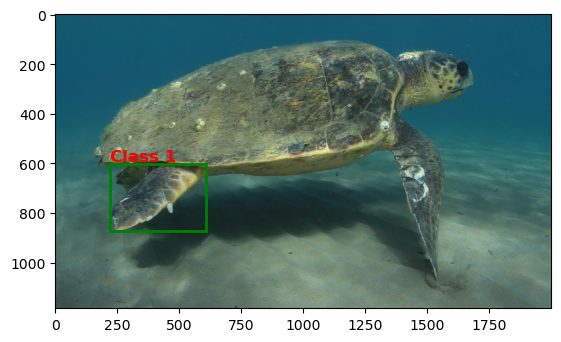

In [14]:
image_path = os.path.join('datasets', 'images','test','aVNthvcWJD.jpg')
label_file = os.path.join('datasets', 'labels','test','aVNthvcWJD.txt')
draw_bboxes(image_path, label_file)

# 3. Object Detection Model

In [15]:
# Write yaml file to specify dataset paths
yaml_path = 'turtles.yaml'
content = """
path: ../datasets
train: images/train
val: images/val
test: images/test

names:
  0: turtle
  1: flipper
  2: head
"""
with open(yaml_path, 'w') as f:
    f.write(content)

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.cuda.empty_cache()

cuda


In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" 

## Load pre-trained weights and train

In [23]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.train(data='turtles.yaml', epochs=50, batch=12, imgsz=540, device=device, lr0=1, augment=True)

Ultralytics 8.3.23  Python-3.12.7 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=turtles.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=540, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

D:\LSL\anaconda3\envs\opencv_env\Lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


AMP: checks passed 
WARNING  imgsz=[540] must be multiple of max stride 32, updating to [544]


train: Scanning D:\LSL\9517\datasets\labels\train.cache... 8651 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8651
val: Scanning D:\LSL\9517\datasets\labels\val.cache... 5372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5372/537


Plotting labels to runs\detect\train22\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 544 train, 544 val
Using 8 dataloader workers
Logging results to runs\detect\train22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       1.2G     0.9328      1.476      1.083         64        544: 100%|██████████| 721/721 [01:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.307      0.826      0.302      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.26G      0.908      1.044      1.062         76        544: 100%|██████████| 721/721 [01:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.304      0.864      0.304      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.22G     0.8953     0.9775      1.061        100        544: 100%|██████████| 721/721 [01:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.308      0.866      0.305      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.21G     0.8697     0.9322      1.051         49        544: 100%|██████████| 721/721 [01:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.308       0.88      0.312      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.22G     0.8341      0.887      1.037         63        544: 100%|██████████| 721/721 [01:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.309      0.884      0.315      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.22G     0.8102     0.8677      1.028         51        544: 100%|██████████| 721/721 [01:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.312      0.893      0.307      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.21G     0.7853     0.8455      1.013         59        544: 100%|██████████| 721/721 [01:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.311      0.895      0.314       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.22G     0.7752     0.8374      1.011         62        544: 100%|██████████| 721/721 [01:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.311      0.892      0.312      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.21G     0.7634     0.8202      1.003         70        544: 100%|██████████| 721/721 [01:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.312      0.905      0.315      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.21G     0.7456     0.8026     0.9974         70        544: 100%|██████████| 721/721 [01:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313        0.9      0.315      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.21G     0.7373     0.7979     0.9943         54        544: 100%|██████████| 721/721 [01:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.312      0.921      0.316      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.21G     0.7269     0.7944      0.991         68        544: 100%|██████████| 721/721 [01:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313       0.92      0.312      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.21G     0.7108     0.7855     0.9846         53        544: 100%|██████████| 721/721 [01:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.312      0.913      0.317       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.22G     0.7113     0.7755     0.9835         52        544: 100%|██████████| 721/721 [01:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.921      0.314      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.22G     0.7065     0.7738     0.9808         68        544: 100%|██████████| 721/721 [01:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.314      0.927      0.313      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.21G     0.6922     0.7624     0.9749         76        544: 100%|██████████| 721/721 [01:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.312      0.918      0.317      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.21G     0.6852     0.7623     0.9754         52        544: 100%|██████████| 721/721 [01:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313       0.93      0.317      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.21G     0.6844     0.7573     0.9719         41        544: 100%|██████████| 721/721 [01:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.932      0.316      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.21G     0.6787     0.7537     0.9716         91        544: 100%|██████████| 721/721 [01:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.312       0.93      0.314      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.22G     0.6717     0.7462     0.9687         53        544: 100%|██████████| 721/721 [01:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.314      0.933      0.314      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.21G     0.6684     0.7405     0.9654         57        544: 100%|██████████| 721/721 [01:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.931      0.314      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.21G     0.6594     0.7379     0.9634         68        544: 100%|██████████| 721/721 [01:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.314       0.93      0.316      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.22G     0.6561     0.7343     0.9612         80        544: 100%|██████████| 721/721 [01:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.942      0.314       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.21G     0.6478      0.728     0.9592         74        544: 100%|██████████| 721/721 [01:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.312      0.939      0.316      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.21G     0.6498     0.7288     0.9573         70        544: 100%|██████████| 721/721 [01:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.314       0.94      0.314      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.21G     0.6466     0.7255     0.9578         91        544: 100%|██████████| 721/721 [01:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.314      0.937      0.316      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.21G     0.6363     0.7198     0.9541         60        544: 100%|██████████| 721/721 [01:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313       0.94      0.314      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.21G      0.632     0.7123     0.9539         60        544: 100%|██████████| 721/721 [01:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.941      0.315      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.21G     0.6314     0.7107     0.9534         54        544: 100%|██████████| 721/721 [01:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.942      0.318       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.21G     0.6242      0.708     0.9492         68        544: 100%|██████████| 721/721 [01:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.943      0.314      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.21G      0.614     0.7035     0.9471         73        544: 100%|██████████| 721/721 [01:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.939      0.314      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.21G     0.6148     0.7021     0.9471         56        544: 100%|██████████| 721/721 [01:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.944      0.315      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.21G     0.6089      0.701     0.9423         79        544: 100%|██████████| 721/721 [01:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.314      0.946      0.314      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.22G     0.6097     0.6974     0.9465         78        544: 100%|██████████| 721/721 [01:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.948      0.311      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.21G     0.6056     0.6949     0.9439         47        544: 100%|██████████| 721/721 [01:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.314      0.943      0.314      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.21G     0.6011     0.6927     0.9401         71        544: 100%|██████████| 721/721 [01:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.944      0.315      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.21G     0.5931     0.6839     0.9374         92        544: 100%|██████████| 721/721 [01:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.945      0.313      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.21G     0.5948     0.6908     0.9405         75        544: 100%|██████████| 721/721 [02:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [01:

                   all       5372       7721      0.313       0.95      0.314      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.21G     0.5862     0.6818     0.9348         73        544: 100%|██████████| 721/721 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.948      0.312      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.21G     0.5802     0.6744     0.9334         78        544: 100%|██████████| 721/721 [01:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.312      0.948      0.314      0.276


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       1.2G     0.4978     0.6277     0.8713         29        544: 100%|██████████| 721/721 [01:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.942      0.311      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.19G     0.4878     0.6199     0.8692         34        544: 100%|██████████| 721/721 [01:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.945      0.314      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       1.2G     0.4862     0.6177     0.8686         35        544: 100%|██████████| 721/721 [01:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.944      0.312      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       1.2G     0.4804     0.6175     0.8656         38        544: 100%|██████████| 721/721 [01:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.949      0.315      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       1.2G     0.4736     0.6137     0.8641         35        544: 100%|██████████| 721/721 [01:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313      0.946      0.313      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       1.2G     0.4693     0.6099     0.8614         30        544: 100%|██████████| 721/721 [01:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313       0.95      0.313      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.19G     0.4625      0.605     0.8598         34        544: 100%|██████████| 721/721 [01:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.952      0.312      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.19G     0.4616     0.6047     0.8586         37        544: 100%|██████████| 721/721 [01:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313      0.949      0.311      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       1.2G     0.4539     0.6005     0.8564         34        544: 100%|██████████| 721/721 [01:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.313       0.95      0.311      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       1.2G     0.4542        0.6     0.8567         33        544: 100%|██████████| 721/721 [01:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:

                   all       5372       7721      0.313       0.95      0.312      0.277



50 epochs completed in 1.914 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 6.2MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics 8.3.23  Python-3.12.7 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [00:


                   all       5372       7721      0.312      0.927      0.318      0.276
                turtle       1765       1768      0.325      0.993       0.33      0.319
               flipper       3544       4239      0.294      0.852      0.294      0.236
                  head       1714       1714      0.317      0.936      0.331      0.273
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000029D2CE59520>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

## Evaluate on test set

In [24]:
model = YOLO('runs\\detect\\train22\\weights\\best.pt') # path for best-performance model
model.val(data='turtles.yaml', split='test', imgsz=540)

WARNING  imgsz=[540] must be multiple of max stride 32, updating to [544]
Ultralytics 8.3.23  Python-3.12.7 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients


val: Scanning D:\LSL\9517\datasets\labels\test.cache... 3177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3177/31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 199/199 [00:


                   all       3177       3804      0.261      0.928      0.267      0.235
                turtle        871        872      0.269      0.982      0.269      0.259
               flipper       1897       2088      0.245      0.861      0.248      0.204
                  head        844        844      0.269      0.942      0.285      0.243
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\val3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000029CEF62EAB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

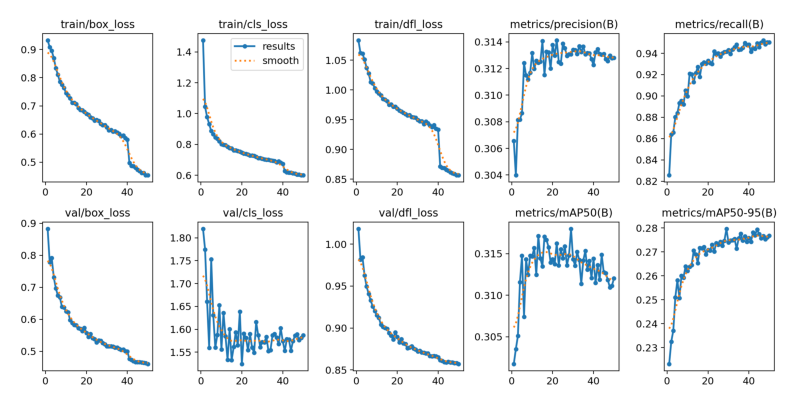

In [22]:
plt.figure(figsize=(10,40))
results = Image.open('runs/detect/train22/results.png')
plt.imshow(results)
plt.axis('off')
plt.show();

# 4. Segmentation Model
use sam2 for batch predicting and faster predicting

In [2]:
os.chdir('9517')

In [3]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = 'D:\\LSL\\sam2\\checkpoints\\sam2.1_hiera_base_plus.pt'
model_cfg = 'D:\\LSL\\sam2\\sam2\\configs\\sam2.1\\sam2.1_hiera_b+.yaml'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = build_sam2(model_cfg, checkpoint, device=device)
mask_predictor = SAM2ImagePredictor(sam)

print(mask_predictor.device)

cuda:0


## Helper functions for batch processing

### Function to predict bounding boxes for given images.

In [4]:
def get_bboxes_batch(image_paths, model):
    # autocast for efficiency. exit after finishing this function
    with torch.autocast("cuda", dtype=torch.bfloat16):
        results = model.predict(image_paths)  # Predict batch
    # results = model.predict(image_paths)  # Predict batch
    
    bboxes_batch = []
    for result in results:
        bboxes = []
        if len(result.boxes) > 0:  # If there are any detections
            for box in result.boxes:
                x_center, y_center, width, height = box.xywhn.cpu().numpy()[0]  # Get normalized values

                # Get image size
                image_width = result.orig_shape[1]
                image_height = result.orig_shape[0]

                # Convert normalized values to pixel values
                x_center = x_center * image_width
                y_center = y_center * image_height
                width = width * image_width
                height = height * image_height

                # Get (x_min, y_min) from center coordinates
                x_min = x_center - (width / 2)
                y_min = y_center - (height / 2)

                # Append the bounding box for this detection
                bboxes.append({
                    'category_id': int(box.cls),
                    'bbox': [int(x_min), int(y_min), int(width), int(height)],
                    'confidence_score': float(box.conf)
                })
        else:
            # No detections, append a dummy bounding box to ensure alignment
            bboxes = [{'category_id': -1, 'bbox': [0, 0, 0, 0], 'confidence_score': 0.0}]

        bboxes_batch.append(bboxes)
    
    return bboxes_batch


#### Test bbox function

In [11]:
import cv2
from ultralytics import YOLO
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bbox_model = YOLO('runs/detect/train22/weights/best.pt').to(device)
print(bbox_model.device)
sample_paths = [os.path.join('datasets', 'images', 'test', 'CpXujdVBac.jpg'), os.path.join('datasets', 'images', 'test', 'abNglVENbz.jpg')]
bboxes_batch = get_bboxes_batch(sample_paths, bbox_model)
bboxes_batch

cuda:0



0: 384x544 1 turtle, 15.8ms
1: 384x544 1 turtle, 2 flippers, 1 head, 15.8ms
Speed: 7.8ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 544)


[[{'category_id': 0,
   'bbox': [926, 761, 117, 117],
   'confidence_score': 0.5625}],
 [{'category_id': 0,
   'bbox': [485, 606, 676, 294],
   'confidence_score': 0.69140625},
  {'category_id': 2,
   'bbox': [985, 628, 147, 110],
   'confidence_score': 0.63671875},
  {'category_id': 1,
   'bbox': [886, 801, 290, 95],
   'confidence_score': 0.5859375},
  {'category_id': 1,
   'bbox': [485, 783, 88, 102],
   'confidence_score': 0.546875}]]

### Function to generate segmentation masks given bouding boxes

In [12]:
def generate_sam_masks_batch(image_paths, bboxes_batch, mask_predictor):
    images_batch = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in image_paths]
    with torch.autocast("cuda", dtype=torch.bfloat16):
        mask_predictor.set_image_batch(images_batch)

    formatted_bboxes_batch = []
    for bboxes in bboxes_batch:
        formatted_bboxes = []
        for bbox in bboxes:
            x_min, y_min, width, height = bbox['bbox']
            x_max = x_min + width
            y_max = y_min + height
            formatted_bboxes.append([x_min, y_min, x_max, y_max])
        formatted_bboxes_batch.append(np.array(formatted_bboxes)) # use np.array

    # Predict masks for the entire batch
    with torch.autocast("cuda", dtype=torch.bfloat16):
        masks_np, iou_predictions_np, _ = mask_predictor.predict_batch(None, None, formatted_bboxes_batch, multimask_output=False)

    # Process predictions for each image
    all_sam_masks = []
    for img_idx, bboxes in enumerate(bboxes_batch):
        sam_masks = []
        for bbox_idx, bbox in enumerate(bboxes):
            best_mask_index = np.argmax(iou_predictions_np[img_idx][bbox_idx])
            best_mask = masks_np[img_idx][bbox_idx][best_mask_index]
            
            sam_masks.append({
                'category_id': bbox['category_id'],
                'mask': best_mask,
                'confidence_score': bbox['confidence_score']
            })

        all_sam_masks.append(sam_masks)
        
    del masks_np, iou_predictions_np # memory managment
        
    return all_sam_masks

### Test generate_sam_masks_batch

In [13]:
masks = generate_sam_masks_batch(sample_paths, bboxes_batch, mask_predictor)
pprint(masks)

[[{'category_id': 0,
   'confidence_score': 0.5625,
   'mask': array([          0,           0,           0, ...,           0,           0,           0], dtype=float32)}],
 [{'category_id': 0,
   'confidence_score': 0.69140625,
   'mask': array([[          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       ...,
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0]], dtype=float32)},
  {'category_id': 2,
   'confidence_score': 0.63671875,
   'mask': array([[          0,           0,           0, ...,           0,           0,           0],
       [          0,

# 5. Construct json file
use COCO format to utilize coco functions

## Helper functions

### Function to transform mask to annotation

In [14]:
import pycocotools.mask as mask_utils
def mask2annotation(mask_dict, category_id, image_id, image_shape, annotation_id):
    # convert the binary mask to RLE
    binary_mask = mask_dict['mask']
    binary_mask = (binary_mask > 0.5).astype(np.uint8)
    # print(f"image_id: {image_id}, Mask shape: {binary_mask.shape}, dtype: {binary_mask.dtype}, unique values: {np.unique(binary_mask)}")
    if binary_mask.ndim != 2:
        # print(f"Warning: Mask for image {image_id}, annotation {annotation_id} is not 2D. Reshape.")
        # Reshape the mask to a 2D zero mask with the expected height and width
        binary_mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)

    rle = mask_utils.encode(np.asfortranarray(binary_mask))

    if rle is None:
        raise ValueError("RLE encoding failed.")
    area = mask_utils.area(rle)
    # rle = mask_utils.decode(rle)
    rle['counts'] = rle['counts'].decode('utf-8')
    # rle['counts'] = list(rle['counts'])
    annotation = {
        'segmentation': rle,
        'area': float(area),
        'image_id': image_id,
        'bbox': list(mask_utils.toBbox(rle)),
        'category_id': category_id + 1,
        'id': annotation_id,
        'iscrowd': 1,
        'score': mask_dict['confidence_score']
    }
    del binary_mask, rle

    return annotation

In [15]:

annotation = mask2annotation(masks[0][0], 1, 1, (1333, 2000),1)
annotation

{'segmentation': {'size': [1333, 2000], 'counts': '``[a2'},
 'area': 0.0,
 'image_id': 1,
 'bbox': [0.0, 0.0, 0.0, 0.0],
 'category_id': 2,
 'id': 1,
 'iscrowd': 1,
 'score': 0.5625}

## Function to constrcut json file
integrate object detection model and segmentation model

In [ ]:
import gc
from PIL import Image
import numpy as np

def coco_json_batch(files_dir, bbox_model, mask_model, reference_coco_json, batch_size=20):
    PRED_ANNS_PATH = os.path.join('datasets', 'pred_annotations_2.json') # to store all in COCO format
    # PRED_MASKS_PATH = os.path.join('datasets', 'pred_masks_2.json') # to store only the masks in original fomrat

     # Temp file to avoid memory usage, will be deleted afterwards
    TEMP_ANNS_PATH = os.path.join('datasets', 'temp_anns.jsonl') # jsonl to avoid reading large chunk of data
    # TEMP_MASKS_PATH = os.path.join('datasets', 'temp_masks.jsonl')
    
    for temp_file in [TEMP_ANNS_PATH]: # clear temp file before starting
        if os.path.exists(temp_file):
            os.remove(temp_file)

    coco_structure = {}
    imgs_section = []
    categories_section = [{'id': 1, 'name': 'turtle'}, {'id': 2, 'name': 'flipper'}, {'id': 3, 'name': 'head'}]

    # Construct a dict to align the image_name with the img_id later
    with open(reference_coco_json, 'r') as f:
        reference_coco = json.load(f)
    reference_img_dict = {os.path.basename(img['file_name']): img['id'] for img in reference_coco['images']}
    
    dict_img_paths = {}
    for root, dirs, files in os.walk(files_dir):
        for file_name in files:
            dict_img_paths[file_name] = os.path.join(root, file_name)
    
    # Prepare batch processing
    img_paths_batch = []
    img_ids_batch = []
    anno_id = 1
    batch_index = 1
    with open(TEMP_ANNS_PATH, 'a') as f_anns:
        # Loop through the images, predict bbox and generate mask in batches
        for file_name, img_path in dict_img_paths.items():
            if file_name in reference_img_dict:
                img_id = reference_img_dict[file_name]
                img_paths_batch.append(img_path)
                img_ids_batch.append(img_id)

                # Process batch if we reach the batch size limit
                if len(img_paths_batch) == batch_size:
                    bboxes_batch = get_bboxes_batch(img_paths_batch, bbox_model)
                    masks_batch = generate_sam_masks_batch(img_paths_batch, bboxes_batch, mask_model)

                    # Append image and annotation information
                    for i, img_path in enumerate(img_paths_batch):
                        with Image.open(img_path) as img:
                            width, height = img.size
                        img_dict = {
                            'id': img_ids_batch[i],
                            'file_name': img_path,
                            'height': height,
                            'width': width
                        }
                        imgs_section.append(img_dict)

                        # Process annotations for each image
                        temp_anns = []
                        for mask in masks_batch[i]:
                            annotation = mask2annotation(mask_dict=mask, category_id=mask['category_id'], image_id=img_ids_batch[i], image_shape=(height, width) ,annotation_id=anno_id)
                            temp_anns.append(annotation)
                            anno_id += 1
                            del annotation
                        f_anns.write(json.dumps(temp_anns) + '\n')
                        del temp_anns

                    # Clear batch lists after processing
                    del masks_batch, bboxes_batch # Memory managment
                    print(f'Batch {batch_index} finished')
                    batch_index += 1
                    img_paths_batch = []
                    img_ids_batch = []
                    gc.collect()

        # If there are remaining images in the batch after loop
        if img_paths_batch:
            bboxes_batch = get_bboxes_batch(img_paths_batch, bbox_model)
            masks_batch = generate_sam_masks_batch(img_paths_batch, bboxes_batch, mask_model)

            for i, img_path in enumerate(img_paths_batch):
                with Image.open(img_path) as img:
                    width, height = img.size
                img_dict = {
                    'id': img_ids_batch[i],
                    'file_name': img_path,
                    'height': height,
                    'width': width
                }
                imgs_section.append(img_dict)

                # Process annotations for each image
                temp_anns = []
                for mask in masks_batch[i]:
                    annotation = mask2annotation(mask_dict=mask, category_id=mask['category_id'], image_id=img_ids_batch[i], image_shape=(height, width) ,annotation_id=anno_id)
                    temp_anns.append(annotation)
                    anno_id += 1
                    del annotation
                f_anns.write(json.dumps(temp_anns) + '\n')
                del temp_anns

            # Clear batch lists after processing
            del masks_batch, bboxes_batch
            gc.collect()
            print(f'Batch {batch_index} finished')
    
    # Finalize COCO structure from temporary files
    with open(TEMP_ANNS_PATH, 'r') as f_anns:
        coco_structure['annotations'] = []
        for line in f_anns:
            coco_structure['annotations'].extend(json.loads(line))
    coco_structure['images'] = imgs_section
    coco_structure['categories'] = categories_section
    # Save COCO json
    with open(PRED_ANNS_PATH, 'w') as f:
        json.dump(coco_structure, f)

    # Clean up temporary files
    # os.remove(TEMP_MASKS_PATH)
    os.remove(TEMP_ANNS_PATH)

## RUN

In [18]:
coco_json_batch('datasets\\images\\test', bbox_model, mask_predictor, 'turtles-data\\data\\annotations.json', batch_size=20)


0: 544x544 1 turtle, 2 flippers, 1 head, 13.0ms
1: 544x544 1 turtle, 1 flipper, 1 head, 13.0ms
2: 544x544 1 turtle, 4 flippers, 1 head, 13.0ms
3: 544x544 1 turtle, 5 flippers, 1 head, 13.0ms
4: 544x544 1 turtle, 3 flippers, 1 head, 13.0ms
5: 544x544 2 turtles, 4 flippers, 1 head, 13.0ms
6: 544x544 1 turtle, 3 flippers, 1 head, 13.0ms
7: 544x544 1 turtle, 2 flippers, 1 head, 13.0ms
8: 544x544 1 turtle, 4 flippers, 1 head, 13.0ms
9: 544x544 1 turtle, 3 flippers, 1 head, 13.0ms
10: 544x544 1 turtle, 1 flipper, 1 head, 13.0ms
11: 544x544 1 turtle, 2 flippers, 1 head, 13.0ms
12: 544x544 1 turtle, 2 flippers, 1 head, 13.0ms
13: 544x544 1 turtle, 3 flippers, 1 head, 13.0ms
14: 544x544 1 turtle, 4 flippers, 1 head, 13.0ms
15: 544x544 1 turtle, 2 flippers, 1 head, 13.0ms
16: 544x544 1 turtle, 2 flippers, 1 head, 13.0ms
17: 544x544 1 turtle, 2 flippers, 1 head, 13.0ms
18: 544x544 1 turtle, 5 flippers, 1 head, 13.0ms
19: 544x544 1 turtle, 1 flipper, 1 head, 13.0ms
Speed: 5.5ms preprocess, 13.0ms

# 6. Visualize

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pycocotools import mask as mask_utils
import os

def visualize_comparison(coco_gt, coco_preds, image_id, gt_img_dir):
    # Load the ground truth image from coco_gt metadata
    gt_img_info = coco_gt.imgs[image_id]
    gt_image_path = os.path.join(gt_img_dir, gt_img_info['file_name'])
    gt_image = np.array(Image.open(gt_image_path))

    # Load the prediction image from coco_preds
    pred_img_info = coco_preds.imgs[image_id]
    pred_image_path = pred_img_info['file_name']
    pred_image = np.array(Image.open(pred_image_path))

    # Create the subplot structure (2 rows x 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # # ========== Ground Truth (GT) ==========

    # GT - Original Image
    axes[0, 0].imshow(gt_image)
    axes[0, 0].set_title('GT - Original')
    axes[0, 0].axis('off')

    # GT - Annotations Overlay
    axes[0, 1].imshow(gt_image)
    axes[0, 1].set_title('GT - Annotations')
    axes[0, 1].axis('off')
    plt.sca(axes[0, 1])  # Set current axis
    cat_ids_gt = coco_gt.getCatIds()
    anns_ids_gt = coco_gt.getAnnIds(imgIds=image_id, catIds=cat_ids_gt, iscrowd=None)
    anns_gt = coco_gt.loadAnns(anns_ids_gt)
    coco_gt.showAnns(anns_gt)

    # GT - Mask
    mask_gt = coco_gt.annToMask(anns_gt[0])
    for i in range(len(anns_gt)):
        mask_gt += coco_gt.annToMask(anns_gt[i])

    axes[0, 2].imshow(mask_gt)
    axes[0, 2].set_title('GT - Mask')
    axes[0, 2].axis('off')

    # # ========== Predictions (Pred) ==========

    # Pred - Original Image
    axes[1, 0].imshow(pred_image)
    axes[1, 0].set_title('Pred - Original')
    axes[1, 0].axis('off')

    # Pred - Annotations Overlay
    axes[1, 1].imshow(pred_image)
    axes[1, 1].set_title('Pred - Annotations')
    axes[1, 1].axis('off')
    plt.sca(axes[1, 1])  # Set current axis
    cat_ids_pred = coco_preds.getCatIds()
    anns_ids_pred = coco_preds.getAnnIds(imgIds=image_id, catIds=cat_ids_pred, iscrowd=None)
    anns_pred = coco_preds.loadAnns(anns_ids_pred)
    coco_preds.showAnns(anns_pred)

    # Pred - Mask
    mask_pred = coco_preds.annToMask(anns_pred[0])
    for i in range(len(anns_pred)):
        mask_pred += coco_preds.annToMask(anns_pred[i])

    axes[1, 2].imshow(mask_pred)
    axes[1, 2].set_title('Pred - Mask')
    axes[1, 2].axis('off')

    # # Show the figure with the correct layout
    fig.suptitle(f'image_iD: {image_id}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [20]:
import random
from pycocotools.coco import COCO

GT_ANNS_PATH = os.path.join('turtles-data', 'data', 'annotations.json')
gt = COCO(GT_ANNS_PATH)
PRED_ANNS_PATH = os.path.join('datasets', 'pred_annotations_2.json')
pred = COCO(PRED_ANNS_PATH)

loading annotations into memory...
Done (t=10.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


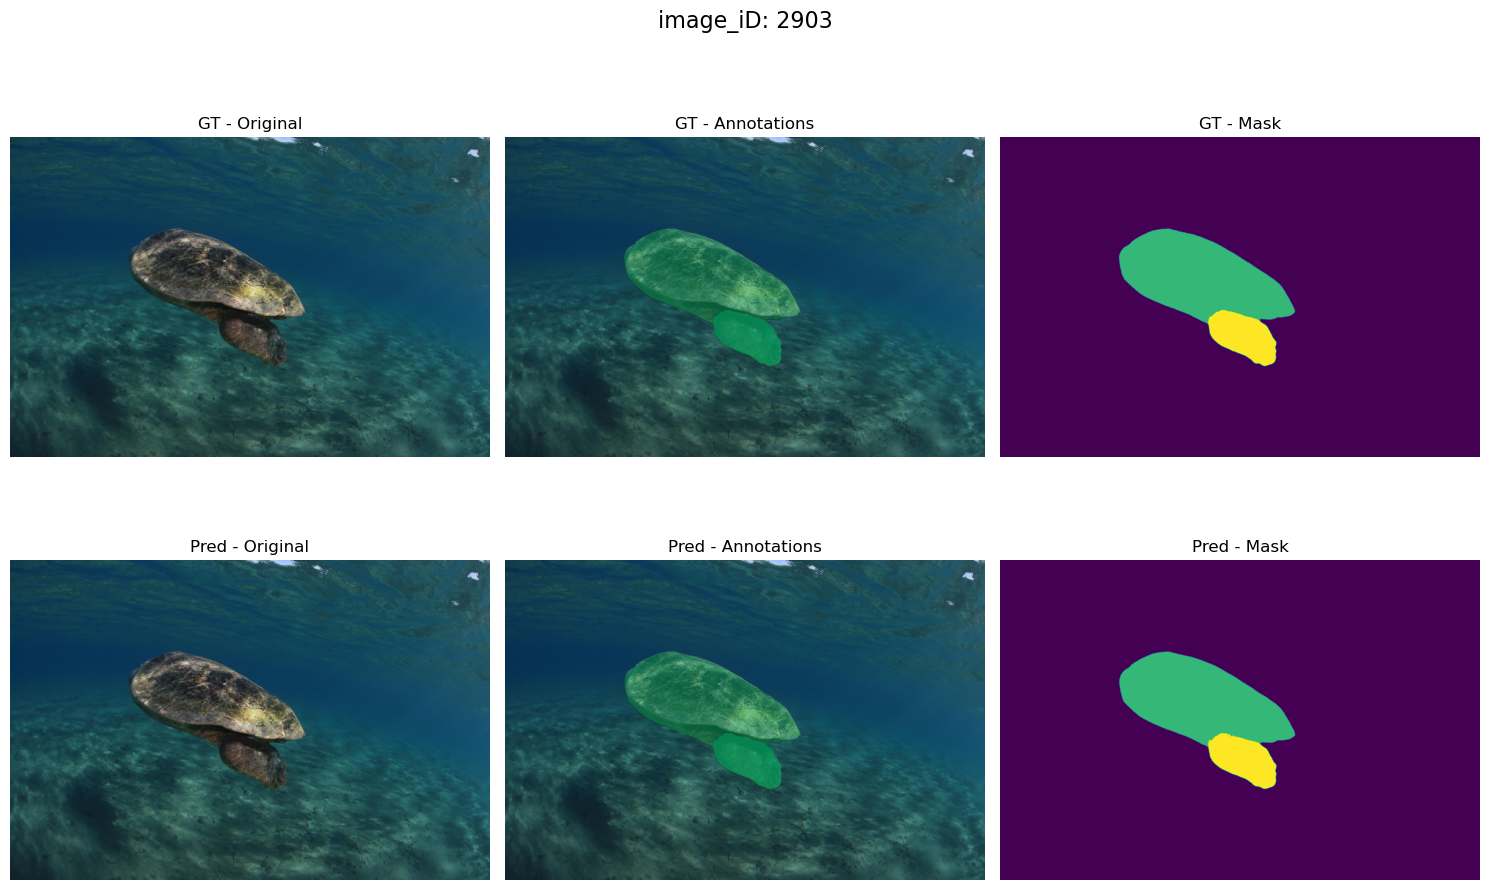

In [24]:
available_image_ids = list(pred.imgs.keys())
image_id = random.choice(available_image_ids)
# image_id = 7868
visualize_comparison(gt, pred, image_id, gt_img_dir=os.path.join('turtles-data', 'data'))

# 7. IoU by COCO rle object
use cocoEval to get overall IOU, but fail

In [25]:
predictions_path = 'datasets/pred_annotations_2.json'

with open(predictions_path, 'r') as f:
    full_structure = json.load(f)


predictions = full_structure['annotations']
for ele in predictions:
    del ele['bbox']

new_predictions_path = 'datasets/pred_anns_only_2.json'
with open(new_predictions_path, 'w') as f:
    json.dump(predictions, f)

In [26]:
from pprint import pprint
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

ground_truth_path = os.path.join('turtles-data', 'data', 'annotations.json')
coco_gt = COCO(ground_truth_path)
predictions_path = os.path.join('datasets', 'pred_anns_only_2.json')
coco_res = coco_gt.loadRes(predictions_path)

loading annotations into memory...
Done (t=10.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.20s)
creating index...
index created!


In [27]:
from pycocotools.cocoeval import COCOeval
import numpy as np

def compute_per_category_mIoU(coco_gt, coco_preds):
    category_ids = coco_gt.getCatIds()
    iou_results = {category_id: [] for category_id in category_ids}  # Collect IoUs per category

    # Initialize COCO evaluation object
    coco_eval = COCOeval(coco_gt, coco_preds, iouType='segm')
    coco_eval.params.catIds = category_ids
    coco_eval.params.useCats = 1
    # coco_eval.params.iouThrs = [0.25, 0.1, 0.95]
    # coco_eval.params.areaRng = [[0 ** 2, 1e5 ** 2],  # all sizes
    #                         [0 ** 2, 32 ** 2],   # small objects
    #                         [32 ** 2, 96 ** 2],  # medium objects
    #                         [96 ** 2, 1e5 ** 2]] # large objects

    coco_eval.evaluate()
    # coco_eval.accumulate()
    print()
    # coco_eval.summarize()

    for (img_id, category_id) in coco_eval.ious.keys():
        ious = coco_eval.ious[(img_id, category_id)]
        if ious is not None and len(ious) > 0:
            iou_results[category_id].extend(ious.flatten())

    # Compute mean IoU per category
    mean_ious = {cat_id: np.mean(iou_results[cat_id]) if iou_results[cat_id] else 0 for cat_id in category_ids}

    return {
        'turtle_mIoU': mean_ious.get(1, 0),
        'flipper_mIoU': mean_ious.get(2, 0),
        'carapace_mIoU': mean_ious.get(3, 0)
    }


In [28]:
results = compute_per_category_mIoU(coco_gt, coco_res)
pprint(results)

Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=16.23s).

{'carapace_mIoU': 0.9310642356569772,
 'flipper_mIoU': 0.3268136299600561,
 'turtle_mIoU': 0.9577294305471412}


# 8. IoU by pixels